# softmax 回归

## 1. 虽然叫回归，但是softmax 解决的是分类问题

- 回归估计是一个连续值
- 分类预测是一个离散类别

## 2. 分类应用举例：

- MINIST
- ImageNet
- human-protein-atlas-image-classification (**Kaggle**)
- malware-classification (**Kaggle**)
- jigsaw-comment-classification (**Kaggle**)

## 3. 从回归到多类分类 -- 均方损失

对分类结果做 one-hot 编码：

$y = [y_1, y_2, , ... , y_n]^T$

$y_i=\left\{\begin{array}{l}1 \text { if } i=y \\ 0 \text { otherwise }\end{array}\right.$

使用均方损失 ($O_i$) 训练：

$\hat{y}=\underset{i}{\operatorname{argmax}} o_i$

该式含义为：取最大化 $O_i$ 对应的 $i$ 作为 $\hat{y}$ 的估计值 

## 4. 无校验比例

需要更置信地识别正确类（大余量）

$O_y - O_i \geq \Delta (y, i)$

## 5. 校验比例

现在我们得到的输出 $O_i$ 是一个向量，我们希望把它转化成每一种分类对应的概率。我们可以通过添加 softmax 操作子实现这一目标，它对 $O_i$ 做如下操作：

$\hat{y_i} = \frac{\exp(O_i)}{\sum_{k} \exp(O_k)}$

此时，$y$ 与 $\hat{y}$ 都是概率，我们可以把两个概率的区别 $y - \hat{y}$ 作为损失

## 6. 交叉熵损失

交叉熵常用来衡量两个概率的区别 $H(p, q) = \sum_{i} - P_i log(q_i)$

将它作为损失：

$l(\mathbf{y}, \hat{\mathbf{y}})=-\sum_i y_i \log \hat{y}_i=-\log \hat{y}_y$

PS：因为除了 $i = y$ 的情况，$i$ 为其他值时 $y_i$ 为 0

其梯度是真实概率和预测概率的区别：

$\partial_{o_i} l(\mathbf{y}, \hat{\mathbf{y}})=\operatorname{softmax}(\mathbf{o})_i-y_i$

## 7. 总结

- Softmax回归是一个多类分类模型
- 使用Softmax操作子得到每个类的预测置信度
- 使用交叉熵来衡量预测和标号的区别

## 8. 损失函数 L2 Loss

$l(y, y^{\prime}) = \frac{1}{2} (y - y^{\prime})^2$

这里推荐这篇讲 [似然函数的文章](https://www.zhihu.com/tardis/bd/ans/1632000258)

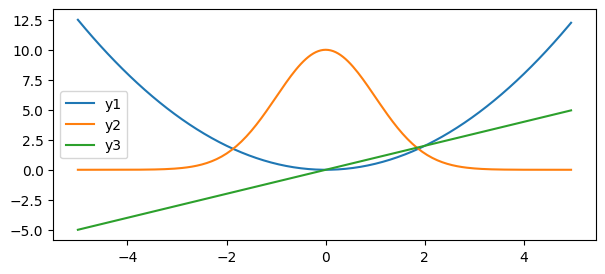

In [1]:
import matplotlib.pyplot as plt
import numpy as np

fig, _ = plt.subplots()
fig.set_size_inches(7, 3)

x = np.array([i/20 - 5 for i in range(200)])
y1 = (0 - x) ** 2 / 2
y2 = 10 * np.exp(-x ** 2 / 2)
y3 = x

plt.plot(x, y1, label='y1')  # 当 y=0 时的损失函数
plt.plot(x, y2, label='y2')  # 损失函数的似然函数，为了看清乘了10
plt.plot(x, y3, label='y3')  # 损失函数的导数
plt.legend()

In [2]:
# PS：对 y1 做符号求导的结果
from sympy import *
x=Symbol("x")
diff((- x) ** 2 / 2, x)

x

## 9. 损失函数 L1 Loss

$l\left(y, y^{\prime}\right)=\left|y-y^{\prime}\right|$

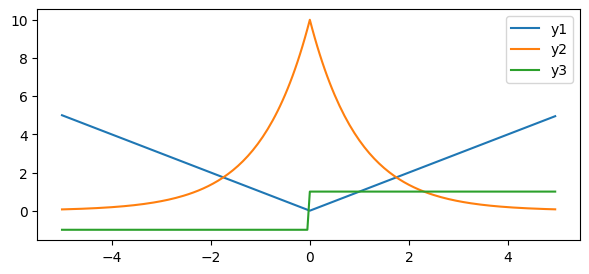

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, _ = plt.subplots()
fig.set_size_inches(7, 3)

x = np.array([i/20 - 5 for i in range(200)])
y1 = np.abs(x)
y2 = 10 * np.exp(- np.abs(x))
y3 = [-1 if e < 0 else 1 for e in x]  # 当 x = 0 时不可导哈，这里不表现了

plt.plot(x, y1, label='y1')  # 当 y=0 时的损失函数
plt.plot(x, y2, label='y2')  # 损失函数的似然函数，为了看清乘了10
plt.plot(x, y3, label='y3')  # 损失函数的导数
plt.legend()

## 10. Huber‘s Robust Loss

$l(y, y^{\prime}) = \left \{ \begin{array} {l} \left| y - y^{\prime} \right| - \frac{1}{2} \text { if } \left| y - y^{\prime}\right| > 1 \\ \frac{1}{2}\left( y - y^{\prime} \right)^2 \text { otherwise} \end{array} \right.$

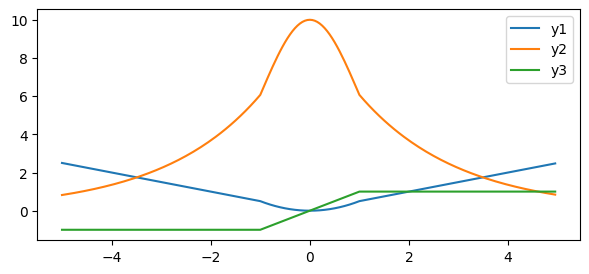

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, _ = plt.subplots()
fig.set_size_inches(7, 3)

x = np.array([i/20 - 5 for i in range(200)])
y1 = [abs(e)/2 if abs(e) > 1 else e**2/2 for e in x]
y2 = [10 * (exp(-abs(e)/2) if abs(e) > 1 else exp(-e**2/2)) for e in x]
y3 = [(1 if e > 1 else -1) if abs(e) > 1 else e for e in x]

plt.plot(x, y1, label='y1')  # 当 y=0 时的损失函数
plt.plot(x, y2, label='y2')  # 损失函数的似然函数，为了看清乘了10
plt.plot(x, y3, label='y3')  # 损失函数的导数
plt.legend()

## 11. 读取Fashion-MNIST数据集

In [5]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

`torchvision.datasets.FashionMNIST` 函数的 train 参数为 True 的时候，下载的是训练数据集，为 False 的时候下载的是测试数据集。测试数据集不参与我们的训练，只用于测试模型的好坏

In [6]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [7]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [8]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [9]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [10]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

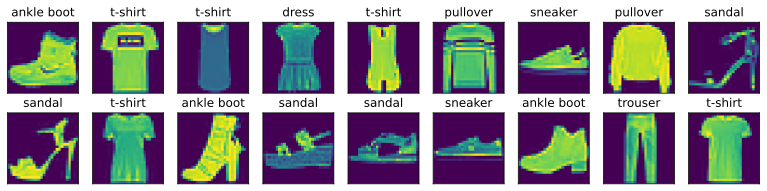

In [11]:
# X里存的是图片，y里存的是标号，函数 get_fashion_mnist_labels 把类型名从标号里取出来
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

读取一小批量数据，大小为`batch_size`

In [12]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'5.37 sec'

PS: 数据读取是一个常见的训练瓶颈，读取一般要求比训练快一些，最好能快很多

In [13]:
def load_data_fashion_mnist(batch_size, resize=None):
    """"下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='../data',
                                                   train=True,
                                                   transform=trans,
                                                   download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='../data',
                                                   train=False,
                                                   transform=trans,
                                                   download=True)

    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_workers()))

In [14]:
load_data_fashion_mnist(3, resize=None)

(<torch.utils.data.dataloader.DataLoader at 0x12a4efd10>,
 <torch.utils.data.dataloader.DataLoader at 0x12a532050>)

## 12. softmax回归从零开始实现

In [15]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [16]:
train_iter, test_iter

(<torch.utils.data.dataloader.DataLoader at 0x12a957850>,
 <torch.utils.data.dataloader.DataLoader at 0x12a775390>)

因为softmax的输入是一个向量，所以需要把图片拉成一个784长的向量。

拉成向量以后会损失掉一些空间信息，这里需要卷积神经网络来继续优化了。

因为我们的数据集有10个类别，所以网络的输出维度为10.

In [17]:
num_inputs = 784
num_outputs = 10

In [18]:
# 对 权重w, 截距b 做初始化，用 normal 方法初始化成一个高斯随机分布的值
# 因为需要计算梯度，所以设置 requires_grad = True
w = torch.normal(0, 0.01, size=(num_inputs, num_outputs),
                 requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

复习：线性代数

给定一个矩阵`X`，我们可以对所有元素求和

In [19]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [20]:
X.sum(0, keepdim=True)

tensor([[5., 7., 9.]])

In [21]:
X.sum(1, keepdim=True)

tensor([[ 6.],
        [15.]])

In [22]:
X.sum()

tensor(21.)

实现softmax

这里我们对每一行进行求和，dim = 1

In [23]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

复习：tensor的广播机制

对于矩阵X

In [24]:
X

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [25]:
X / torch.tensor([0.5, 0.5, 0.5])

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]])

验证一下softmax函数有没有写对

In [26]:
# 我们将X初始化成一个均值为0，方差为1的，2行5列的矩阵
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1)

(tensor([[ 0.0140,  0.2691, -0.6399, -0.9082,  2.3732],
         [-0.3327,  0.6811, -0.2270, -1.4436,  0.0492]]),
 tensor([[0.0725, 0.0936, 0.0377, 0.0288, 0.7674],
         [0.1501, 0.4137, 0.1668, 0.0494, 0.2199]]),
 tensor([1.0000, 1.0000]))

In [27]:
# reshape 中的 -1 代表让机器自己算一下，w.shape[0]是784
def net(X):
    return softmax(torch.matmul(X.reshape((-1, w.shape[0])), w) + b)

In [28]:
w.shape[0]

784

补充知识点

创建一个数据y_hat，其中包含2个样本在3个类别的预测概率，使用y作为y_hat中概率的索引

In [29]:
y = torch.tensor([0, 2])  # 其中0，2代表两种类别
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# 其中两个向量代表两个样本，三个分量代表三个类别的概率
y_hat[[0, 1], y]
# 代表从y_hat中把第0个样本的第y_0个分量取出，把第1个样本的第y_1个样本取出

tensor([0.1000, 0.5000])

实现交叉熵损失函数

range(len(y_hat))表示取遍y_hat中所有样本

In [30]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

- y_hat是可计算的，知道X即图像向量，并且知道w, b就可以计算y_hat
- y在训练时是已知的，因为训练极已经给出了X与其对应的标号y

因此交叉熵是可计算的。

将预测类别与真实y进行比较

In [31]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) and y_hat.shape[1] > 1: # 图像向量长度大于1
#         print(y_hat)
        y_hat = y_hat.argmax(axis=1)
#         print(y_hat)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

我们可以评估在任意模型net的准确率

In [32]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集熵模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
        # 评估模式指不计算梯度，只计算forward        
    metric = Accumulator(2)  # 累计器，两个分量，分别是：正确预测数、预测总数 
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [33]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [34]:
evaluate_accuracy(net, test_iter)

0.0873

In [35]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [36]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [37]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


In [38]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

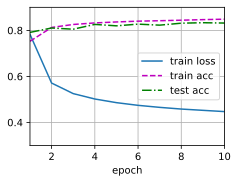

In [39]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 13. 预测

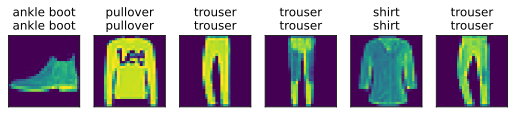

In [40]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

In [41]:
w, b

(tensor([[-0.0155,  0.0071, -0.0092,  ..., -0.0013, -0.0061,  0.0092],
         [ 0.0179, -0.0029,  0.0029,  ...,  0.0003, -0.0176, -0.0148],
         [ 0.0064, -0.0007,  0.0016,  ..., -0.0014, -0.0104,  0.0304],
         ...,
         [-0.0335,  0.0150,  0.0509,  ..., -0.0049, -0.0288,  0.0196],
         [-0.0275,  0.0007,  0.0053,  ..., -0.0027,  0.0026,  0.0083],
         [-0.0043,  0.0043,  0.0100,  ...,  0.0037, -0.0030, -0.0190]],
        requires_grad=True),
 tensor([ 0.2789, -0.3041, -0.0947,  0.1847, -0.9139,  1.9063,  0.4238, -0.1052,
         -0.4228, -0.9530], requires_grad=True))